In [1]:
import os
import cv2
import librosa
import IPython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from warnings import filterwarnings
from sklearn.preprocessing import LabelEncoder
filterwarnings("ignore")

c:\Users\jryan\bird_sound_env\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\jryan\bird_sound_env\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\jryan\bird_sound_env\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility 

In [2]:
file_path = 'C:/Users/jryan/Documents/Bird Sound Detection/Birds Sounds/Asian Koel/XC995636 - Asian Koel - Eudynamys scolopaceus.wav'
audio_data, sample_rate = librosa.load(file_path)

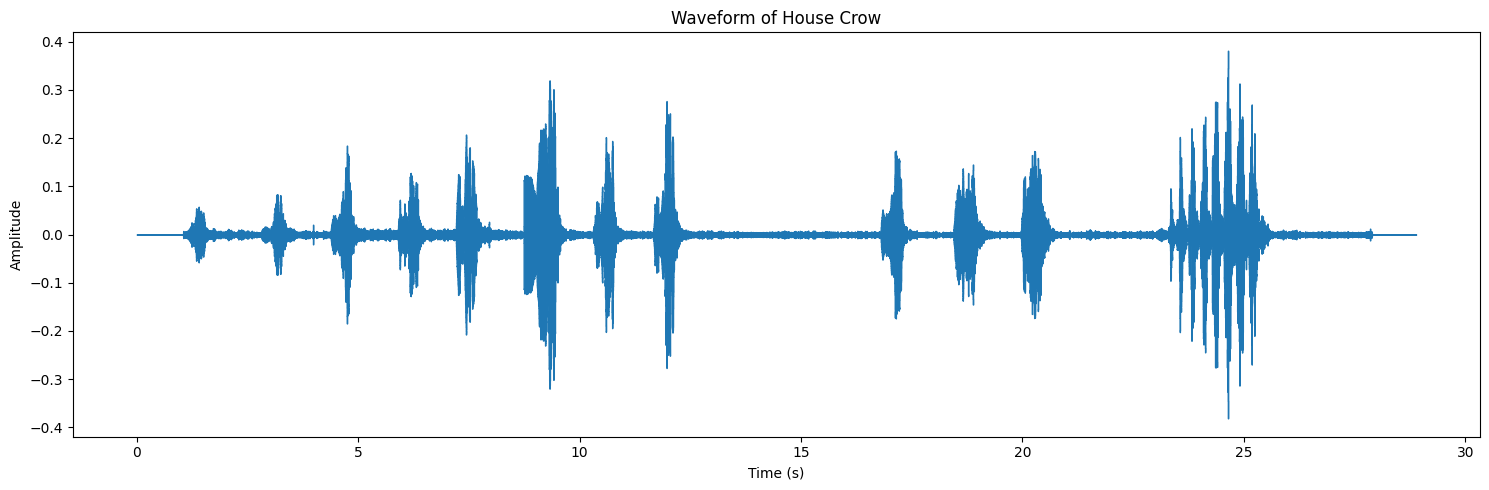

In [4]:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(audio_data, sr=sample_rate)
plt.title('Waveform of House Crow')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()


In [5]:
audio_data
import soundfile as sf

In [12]:


# --- CONFIG ---
input_root = 'C:/Users/jryan/Documents/Bird Sound Detection/Birds Sounds'
output_root = 'C:/Users/jryan/Documents/Bird Sound Detection/Voices of Birds'

frame_length = 2048
hop_length = 512
threshold = 0.1
min_duration = 1.0  # in seconds
merge_gap_sec = 0.5


def extract_segments(y, sr):
    energy = np.array([
        sum(abs(y[i:i + frame_length] ** 2))
        for i in range(0, len(y), hop_length)
    ])

    if np.max(energy) == 0:
        return []

    energy = energy / np.max(energy)
    high_energy_indices = np.where(energy > threshold)[0]

    segments = []
    if len(high_energy_indices) > 0:
        start = high_energy_indices[0]
        for i in range(1, len(high_energy_indices)):
            if high_energy_indices[i] > high_energy_indices[i - 1] + 1:
                end = high_energy_indices[i - 1]
                segments.append((start, end))
                start = high_energy_indices[i]
        segments.append((start, high_energy_indices[-1]))

    # Merge nearby segments
    min_gap_frames = int(merge_gap_sec * sr / hop_length)
    merged_segments = []
    if segments:
        start, end = segments[0]
        for i in range(1, len(segments)):
            if segments[i][0] - end <= min_gap_frames:
                end = segments[i][1]
            else:
                merged_segments.append((start, end))
                start, end = segments[i]
        merged_segments.append((start, end))

    return merged_segments


def process_audio(audio_path, bird_name, output_dir):
    try:
        y, sr = librosa.load(audio_path, sr=None)
        segments = extract_segments(y, sr)
        min_samples = int(min_duration * sr)
        base_name = os.path.splitext(os.path.basename(audio_path))[0]

        for idx, (start_frame, end_frame) in enumerate(segments):
            start_sample = start_frame * hop_length
            end_sample = min(len(y), (end_frame + 1) * hop_length)
            clip = y[start_sample:end_sample]

            if len(clip) >= min_samples:
                filename = f"{bird_name}_{base_name}_segment{idx + 1}.wav"
                segment_path = os.path.join(output_dir, filename)
                sf.write(segment_path, clip, sr)
            else:
                continue

    except Exception as e:
        print(f"❌ Error processing {audio_path}: {e}")


def main():
    # Count total files
    total_files = sum(
        len(files) for _, _, files in os.walk(input_root)
        if files
    )

    with tqdm(total=total_files, desc='Processing audio files') as pbar:
        for bird_name in os.listdir(input_root):
            bird_folder = os.path.join(input_root, bird_name)
            if not os.path.isdir(bird_folder):
                continue

            output_dir = os.path.join(output_root, bird_name)
            os.makedirs(output_dir, exist_ok=True)

            for file in os.listdir(bird_folder):
                audio_path = os.path.join(bird_folder, file)
                process_audio(audio_path, bird_name, output_dir)
                pbar.update(1)


if __name__ == "__main__":
    main()


Processing audio files:   0%|          | 0/401 [00:00<?, ?it/s]

Processing audio files:  59%|█████▉    | 237/401 [03:10<01:00,  2.73it/s]

❌ Error processing C:/Users/jryan/Documents/Bird Sound Detection/Birds Sounds\Little Grebe\XC1006012 - Little Grebe - Tachybaptus ruficollis.mp3: 


Processing audio files: 100%|██████████| 401/401 [05:20<00:00,  1.25it/s]


In [5]:
sample_rate

22050

In [6]:
mfcc_features=librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=20)

In [7]:
mfcc_features.shape

(20, 2384)

In [8]:
mfcc_features

array([[-456.8155   , -344.87537  , -316.34216  , ..., -282.53564  ,
        -287.141    , -326.88504  ],
       [  24.988432 ,   49.768707 ,   47.99068  , ...,   30.25683  ,
          34.118797 ,   43.007484 ],
       [ -38.062973 ,  -65.70743  ,  -76.89037  , ...,  -91.58548  ,
         -90.972015 ,  -79.73668  ],
       ...,
       [  -3.6883225,   -2.481793 ,    3.2050545, ...,    4.432867 ,
           3.2776487,    1.3413025],
       [   1.8298839,    4.915045 ,    5.1003933, ...,    2.1258693,
           1.0632713,   -2.2453845],
       [   4.1333246,    5.8194485,    3.4887276, ...,   -2.3676863,
          -5.739766 ,   -8.410791 ]], shape=(20, 2384), dtype=float32)

In [10]:
print(2)

2


In [13]:
def audio_to_tensors(audio_file):
    # Extract the Signal and Sample_Rate from Audio
    audio, sample_rate =librosa.load(audio_file)

    # Extract the MFCC Features and Aggrigate
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_features = np.mean(mfccs_features, axis=1)

    # Convert into Tensors
    mfccs_tensors = tf.convert_to_tensor(mfccs_features, dtype=tf.float32)

    return mfccs_tensors

In [14]:
directory = 'C:/Users/jryan/Documents/Bird Sound Detection/Voices of Birds'

extracted_features = []

# Count the total number of files
total_files = sum(len(files) for _, _, files in os.walk(directory))

# Initialize tqdm with the total number of files
with tqdm(total=total_files, desc='Processing files') as pbar:

  for target_class in os.listdir(directory):                               # List of All Target Folder Names in Directory

      target_class_path = os.path.join(directory, target_class)            # Make a Target Folder Path in Directory

      for audio_file in os.listdir(target_class_path):                     # List of All Audio Files in Target Folder

          audio_path = os.path.join(directory, target_class, audio_file)   # Make a Audio File Path from Target Folder in Directory

          features = audio_to_tensors(audio_path)                          # Extract the Features from the Audio File

          extracted_features.append([features, target_class])              # Append the Features and Target_Class in List

          pbar.update(1)    

Processing files: 100%|██████████| 713/713 [00:14<00:00, 47.99it/s]


In [29]:
extracted_features[100]

[<tf.Tensor: shape=(40,), dtype=float32, numpy=
 array([-2.58194427e+02,  6.49494629e+01, -3.28640633e+01,  2.00698814e+01,
         7.71784401e+00,  1.87666333e+00, -1.55773611e+01,  1.02807875e+01,
         4.44496775e+00, -1.25448866e+01, -8.78900433e+00,  1.38470831e+01,
        -8.16600621e-01, -1.16691673e+00, -5.60839033e+00,  4.06663704e+00,
         2.58769721e-01,  1.96286607e+00, -2.20992661e+00, -3.60661954e-01,
        -3.27395725e+00,  3.10571885e+00, -4.67999601e+00, -6.78469241e-01,
         2.54399967e+00,  9.31148911e+00,  3.67293835e+00,  3.18206406e+00,
         8.48757088e-01,  5.30969286e+00, -4.38267040e+00, -1.60705531e+00,
         1.07264556e-01,  2.28663015e+00, -3.16754985e+00,  3.03286195e-01,
        -1.02093808e-01,  1.28402293e+00, -3.54025722e+00,  2.27296233e+00],
       dtype=float32)>,
 'Black Kite']

In [30]:
features_df = pd.DataFrame(extracted_features, columns=['features', 'class'])
features_df

,features,class
0,"(tf.Tensor(-288.29715, shape=(), dtype=float32...",Ashy Prinia
1,"(tf.Tensor(-279.7674, shape=(), dtype=float32)...",Ashy Prinia
2,"(tf.Tensor(-295.47308, shape=(), dtype=float32...",Ashy Prinia
3,"(tf.Tensor(-180.62357, shape=(), dtype=float32...",Ashy Prinia
4,"(tf.Tensor(-448.22287, shape=(), dtype=float32...",Ashy Prinia
...,...,...
708,"(tf.Tensor(-196.59158, shape=(), dtype=float32...",White-throated Kingfisher
709,"(tf.Tensor(-167.84001, shape=(), dtype=float32...",White-throated Kingfisher
710,"(tf.Tensor(-521.9452, shape=(), dtype=float32)...",White-throated Kingfisher
711,"(tf.Tensor(-318.12906, shape=(), dtype=float32...",White-throated Kingfisher


In [31]:
target_encoding = LabelEncoder().fit_transform(features_df['class'])
target_encoding

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7

In [32]:

# Adding Encoded Class Labels Column to DataFrame

features_df['target'] = target_encoding.tolist()
features_df

,features,class,target
0,"(tf.Tensor(-288.29715, shape=(), dtype=float32...",Ashy Prinia,0
1,"(tf.Tensor(-279.7674, shape=(), dtype=float32)...",Ashy Prinia,0
2,"(tf.Tensor(-295.47308, shape=(), dtype=float32...",Ashy Prinia,0
3,"(tf.Tensor(-180.62357, shape=(), dtype=float32...",Ashy Prinia,0
4,"(tf.Tensor(-448.22287, shape=(), dtype=float32...",Ashy Prinia,0
...,...,...,...
708,"(tf.Tensor(-196.59158, shape=(), dtype=float32...",White-throated Kingfisher,23
709,"(tf.Tensor(-167.84001, shape=(), dtype=float32...",White-throated Kingfisher,23
710,"(tf.Tensor(-521.9452, shape=(), dtype=float32)...",White-throated Kingfisher,23
711,"(tf.Tensor(-318.12906, shape=(), dtype=float32...",White-throated Kingfisher,23


In [33]:
prediction_dict = features_df.set_index('target')['class'].to_dict()
prediction_dict

{0: 'Ashy Prinia',
 1: 'Asian Koel',
 2: 'Black Drongo',
 3: 'Black Kite',
 4: 'Blue Rock-Pigeon',
 5: 'Brahminy Kite',
 6: 'Common Hoopoe',
 7: 'Common Myna',
 8: 'Comon Coot',
 9: 'Green Bee-eater',
 10: 'House Crow',
 11: 'House Sparrow',
 12: 'Indian Pond-Heron',
 13: 'Indian Robin',
 14: 'Indian Roller',
 15: 'Little Grebe',
 16: 'Purple Waterhen',
 17: 'Red-wattled Lapwing',
 18: 'Red-whiskered Bulbul',
 19: 'Rose-ringed Parakeet',
 20: 'Shikra',
 21: 'Spotted Owlet',
 22: 'White-cheeked Barbet',
 23: 'White-throated Kingfisher'}

In [37]:
import json
with open(file='C:/Users/jryan/Documents/Bird Sound Detection/Code/prediction.json', mode='w') as f:
    json.dump(prediction_dict, f)

In [48]:
import json


with open('C:/Users/jryan/Documents/Bird Sound Detection/Code/prediction.json', 'w') as f:
    json.dump(prediction_dict, f, indent=4)


In [49]:
with open('C:/Users/jryan/Documents/Bird Sound Detection/Code/prediction.json', 'r') as f:
    content = f.read()
    print("File content:", repr(content))


File content: '{\n    "0": "Ashy Prinia",\n    "1": "Asian Koel",\n    "2": "Black Drongo",\n    "3": "Black Kite",\n    "4": "Blue Rock-Pigeon",\n    "5": "Brahminy Kite",\n    "6": "Common Hoopoe",\n    "7": "Common Myna",\n    "8": "Comon Coot",\n    "9": "Green Bee-eater",\n    "10": "House Crow",\n    "11": "House Sparrow",\n    "12": "Indian Pond-Heron",\n    "13": "Indian Robin",\n    "14": "Indian Roller",\n    "15": "Little Grebe",\n    "16": "Purple Waterhen",\n    "17": "Red-wattled Lapwing",\n    "18": "Red-whiskered Bulbul",\n    "19": "Rose-ringed Parakeet",\n    "20": "Shikra",\n    "21": "Spotted Owlet",\n    "22": "White-cheeked Barbet",\n    "23": "White-throated Kingfisher"\n}'


In [50]:
features = features_df['features'].tolist()
features

[<tf.Tensor: shape=(40,), dtype=float32, numpy=
 array([-2.88297150e+02,  4.56343918e+01,  1.25586472e+01,  4.83524704e+01,
        -4.74160957e+01,  2.97700214e+01, -3.04037762e+01,  7.32823491e-01,
        -6.83177376e+00, -8.51608181e+00, -1.07630615e+01, -5.08935809e-01,
        -2.21725292e+01, -6.50266266e+00, -8.60913372e+00, -1.57577982e+01,
        -1.27930975e+01, -2.16996169e+00, -1.14472265e+01,  5.79008222e-01,
        -2.63292313e+00, -3.60496193e-01, -9.24038506e+00,  3.80783463e+00,
        -1.11554489e+01,  2.43573070e-01, -1.19046192e+01, -4.44332552e+00,
         8.44893381e-02, -1.00044184e+01, -3.73979163e+00, -1.98459017e+00,
        -1.11585102e+01,  3.77604651e+00, -5.25502300e+00,  4.33394718e+00,
        -2.88250494e+00,  2.03612995e+00, -3.10128522e+00, -2.27968931e+00],
       dtype=float32)>,
 <tf.Tensor: shape=(40,), dtype=float32, numpy=
 array([-2.7976740e+02,  5.2005371e+01,  1.3455708e+01,  3.4269951e+01,
        -4.5154770e+01,  3.8226505e+01, -3.2285

In [51]:
# Converting Targets into Lists
target = features_df['target'].tolist()
print(target)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11,

In [52]:
features_tensor = tf.convert_to_tensor(features)
target_tensor = tf.convert_to_tensor(target)

In [53]:
features_tensor

<tf.Tensor: shape=(713, 40), dtype=float32, numpy=
array([[-288.29715   ,   45.63439   ,   12.558647  , ...,    2.03613   ,
          -3.1012852 ,   -2.2796893 ],
       [-279.7674    ,   52.00537   ,   13.455708  , ...,   -1.0222783 ,
          -2.3011456 ,   -1.971678  ],
       [-295.47308   ,   50.54693   ,   12.976332  , ...,   -2.4525762 ,
          -4.167848  ,   -1.4160639 ],
       ...,
       [-521.9452    , -103.72347   ,  -43.43904   , ...,    0.8430337 ,
           0.55133814,    3.7829933 ],
       [-318.12906   ,   29.480827  ,  -58.9798    , ...,    3.9315796 ,
          -1.1257516 ,    0.9745285 ],
       [-324.01138   ,   36.074413  ,  -54.687946  , ...,    5.3845263 ,
          -0.80822885,    1.0131863 ]], shape=(713, 40), dtype=float32)>

In [54]:
target_tensor

<tf.Tensor: shape=(713,), dtype=int32, numpy=
array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,

In [55]:
dataset = tf.data.Dataset.from_tensor_slices((features_tensor, target_tensor))
dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(40,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [56]:
batch_size = 32
dataset = dataset.batch(batch_size)
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [57]:
def train_validation_test_split(dataset, train_size=0.8, validation_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):

    dataset_batch_count = len(dataset)                                                  # Batch Images dataset Length is 68
    train_batch_count = int(dataset_batch_count * train_size)                           # int(68*0.8) ---> 54 Batches are Training
    validation_test_batch_count = int(dataset_batch_count * validation_size)            # int(68*0.1) ---> 6 Batches are validation & Remaining Testing

    if shuffle:
        dataset = dataset.shuffle(buffer_size=shuffle_size)                             # Suffling the Dataset help to Model Understand the Data Well

    train_ds = dataset.take(train_batch_count)                                          # First 54 Batches are Training_Dataset
    validation_ds = dataset.skip(train_batch_count).take(validation_test_batch_count)   # Remaining 14 Batches ---> Next 6 Batch are Validation_Dataset
    test_ds = dataset.skip(train_batch_count).skip(validation_test_batch_count)         # Pending 8 Batches are Testing

    return train_ds, validation_ds, test_ds
     

In [58]:
train_ds, validation_ds, test_ds = train_validation_test_split(dataset)
len(train_ds), len(validation_ds), len(test_ds)

(18, 2, 3)

(40,)
[-2.58107574e+02  5.02511520e+01 -6.94462357e+01  2.49602947e+01
  5.35638428e+00  2.72308111e+00 -1.78871498e+01  1.86169090e+01
  1.09952564e+01 -1.18464956e+01 -1.13119926e+01  1.40870695e+01
  1.15682440e+01 -6.73581076e+00 -4.33395100e+00  1.18391752e+01
 -4.71881962e+00 -4.14922953e+00 -1.18471825e+00  1.40283489e+00
 -1.76573575e+00  4.07976151e+00 -2.17830968e+00  6.54460192e-02
 -6.98968828e-01  7.93592882e+00 -2.06583595e+00 -3.50491929e+00
 -2.39293635e-01  7.03550386e+00 -5.07011080e+00 -1.25591946e+00
  4.09332991e-01  2.55927205e+00 -4.71487671e-01 -2.26293325e+00
 -4.92327881e+00  5.61718559e+00 -3.81665421e+00 -3.01133132e+00]

(32,)
3



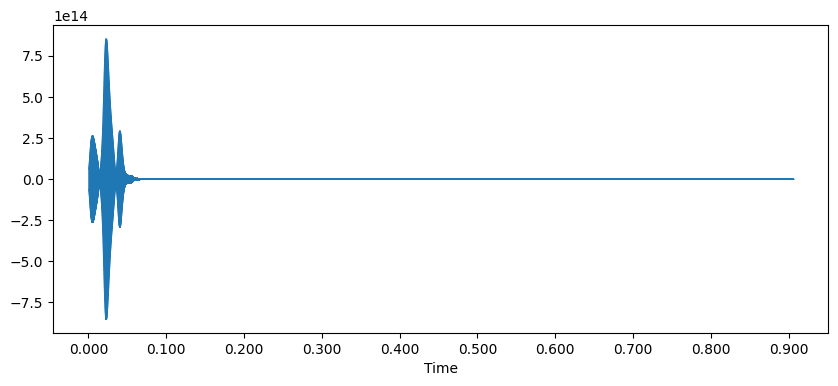

In [59]:
for audio_batch, label_batch in train_ds.take(1):
    print(audio_batch.numpy()[0].shape)
    print(audio_batch.numpy()[0])
    print()

    print(label_batch.numpy().shape)
    print(label_batch.numpy()[0])
    print()

    audio = librosa.feature.inverse.mfcc_to_audio(audio_batch.numpy())

    # Plot the reconstructed audio waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio)
    plt.show()

In [60]:
train_ds = train_ds.cache().shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

# Validation Dataset
validation_ds = validation_ds.cache().shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

# Testing Dataset
test_ds = test_ds.cache().shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

In [61]:
mfcc_features = 40    # Extracted features from Audio
channel = 1           # Mono Channel
target = 114          # Output Classes

input_shape = (mfcc_features, channel)
input_shape

(40, 1)

In [63]:
from tensorflow import keras
model = keras.Sequential([

            # Input Layer
            keras.layers.Input(shape=input_shape),

            # 1st Conv Layer
            keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPool1D(pool_size=2, padding='same'),

            # 2nd Conv Layer
            keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPool1D(pool_size=2, padding='same'),

            # 3rd Conv Layer
            keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPool1D(pool_size=2, padding='same'),

            # Flatten and Convert into 1-Dimentional Vector
            keras.layers.Flatten(),

            # 1st Fully Connected Dense Layer
            keras.layers.Dense(units=512, activation='relu', kernel_regularizer=keras.regularizers.L2(l2=1e-2)),
            keras.layers.Dropout(rate=0.3),

            # 2nd Fully Connected Dense Layer
            keras.layers.Dense(units=512, activation='relu', kernel_regularizer=keras.regularizers.L2(l2=1e-2)),
            keras.layers.Dropout(rate=0.3),

            # Output Layer
            keras.layers.Dense(units=target, activation='softmax')
        ])

model

<Sequential name=sequential, built=True>

In [65]:

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 38, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 38, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 19, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 17, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 17, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 9, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 7, 256)         │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 114)            │        58,482 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,144,434 (4.37 MB)

 Trainable params: 1,143,154 (4.36 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [66]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model

<Sequential name=sequential, built=True>

In [67]:
history = model.fit(train_ds,
                    batch_size=batch_size,
                    epochs=700,
                    verbose=1,
                    validation_data = validation_ds)
history

Epoch 1/700
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.0090 - loss: 17.4210 - val_accuracy: 0.0000e+00 - val_loss: 16.9445
Epoch 2/700
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0253 - loss: 17.2016 - val_accuracy: 0.0000e+00 - val_loss: 16.8455
Epoch 3/700
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.0235 - loss: 17.0282 - val_accuracy: 0.0000e+00 - val_loss: 16.7918
Epoch 4/700
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.0398 - loss: 16.8189 - val_accuracy: 0.0000e+00 - val_loss: 16.7485
Epoch 5/700
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0398 - loss: 16.6970 - val_accuracy: 0.0000e+00 - val_loss: 16.6862
Epoch 6/700
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.0597 - loss: 16.5034 - val_accuracy: 0.0000e+00 - val_loss: 16.6279
Epoch 7/700
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.0615 - loss: 16.4232 - val_accuracy: 0.0000e+00 - val_loss: 16.5691
Epoch 8/700
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy

In [68]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extracting Loss Metrics from Training History
loss = history.history['loss']
val_loss = history.history['val_loss']
     

len(acc), len(val_acc), len(loss), len(val_loss)

(700, 700, 700, 700)

In [73]:
model.save('sound_model.keras')

In [72]:
model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6562 - loss: 3.1441


[3.1440703868865967, 0.65625]

Text(0.5, 1.0, 'Training vs Validation Loss')

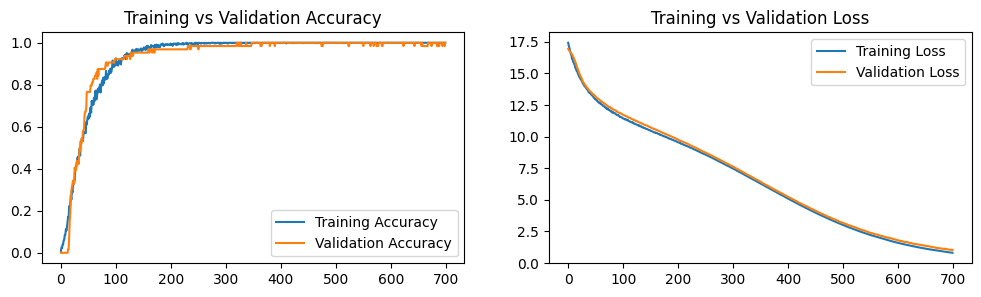

In [74]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

In [122]:
def prediction(audio_file):

    # Load the Prediction JSON File to Predict Target_Label
    with open('prediction.json', mode='r') as f:
        prediction_dict = json.load(f)

    # Extract the Audio_Signal and Sample_Rate from Input Audio
    audio, sample_rate =librosa.load(audio_file)

    # Extract the MFCC Features and Aggrigate
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_features = np.mean(mfccs_features, axis=1)

    # Reshape MFCC features to match the expected input shape for Conv1D both batch & feature dimension
    mfccs_features = np.expand_dims(mfccs_features, axis=0)
    mfccs_features = np.expand_dims(mfccs_features, axis=2)

    # Convert into Tensors
    mfccs_tensors = tf.convert_to_tensor(mfccs_features, dtype=tf.float32)

    # Load the Model and Prediction
    model = tf.keras.models.load_model('sound_model.keras')
    prediction = model.predict(mfccs_tensors)

    # Find the Maximum Probability Value
    target_label = np.argmax(prediction)

    # Find the Target_Label Name using Prediction_dict
    predicted_class = prediction_dict[str(target_label)]
    confidence = round(np.max(prediction)*100, 2)

    print(f'Predicted Class : {predicted_class}')
    print(f'Confident : {confidence}%')
     

In [143]:
predict_from_segments('C:/Users/jryan/Documents/Bird Sound Detection/Voices of Birds/Brahminy Kite/Brahminy Kite_XC575564 - Brahminy Kite - Haliastur indus_segment7.wav')


📁 Audio File: Brahminy Kite_XC575564 - Brahminy Kite - Haliastur indus_segment7.wav
🔍 Total segments detected: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
  ▶️ Segment 1: Blue Rock-Pigeon (9.91%)

✅ Final Prediction: Blue Rock-Pigeon (9.91%)



'Blue Rock-Pigeon'

In [142]:
predict_from_segments('C:/Users/jryan/Downloads/XC311308 - White-throated Kingfisher - Halcyon smyrnensis.mp3')


📁 Audio File: XC311308 - White-throated Kingfisher - Halcyon smyrnensis.mp3
🔍 Total segments detected: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
  ▶️ Segment 1: Blue Rock-Pigeon (12.24%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
  ▶️ Segment 2: Blue Rock-Pigeon (11.34%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
  ▶️ Segment 3: Blue Rock-Pigeon (12.63%)

✅ Final Prediction: Blue Rock-Pigeon (12.63%)



'Blue Rock-Pigeon'

In [141]:
predict_from_segments("C:/Users/jryan/Documents/Bird Sound Detection/Voices of Birds/Shikra/Shikra_XC510776 - Shikra - Accipiter badius_segment1.wav")


📁 Audio File: Shikra_XC510776 - Shikra - Accipiter badius_segment1.wav
🔍 Total segments detected: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
  ▶️ Segment 1: Blue Rock-Pigeon (11.3%)

✅ Final Prediction: Blue Rock-Pigeon (11.3%)



'Blue Rock-Pigeon'

In [146]:
def predict_segment(audio_segment, sample_rate):
    with open('prediction.json', mode='r') as f:
        prediction_dict = json.load(f)

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio_segment, sr=sample_rate, n_mfcc=40)

    # Average across time (just like training)
    mfccs = np.mean(mfccs, axis=1)  # shape: (40,)

    # Reshape to match model input shape: (1, 40, 1)
    mfccs = np.reshape(mfccs, (1, 40, 1))
    mfccs_tensor = tf.convert_to_tensor(mfccs, dtype=tf.float32)

    model = tf.keras.models.load_model('sound_model.keras')
    prediction = model.predict(mfccs_tensor)

    target_label = np.argmax(prediction)
    predicted_class = prediction_dict[str(target_label)]
    confidence = float(np.max(prediction))

    return predicted_class, confidence


In [147]:
def predict_from_segments(audio_path):
    try:
        y, sr = librosa.load(audio_path, sr=None)
        segments = extract_segments(y, sr)
        min_samples = int(min_duration * sr)

        if not segments:
            print("❌ No segments found in audio.")
            return None

        predictions = []

        print(f"\n📁 Audio File: {os.path.basename(audio_path)}")
        print(f"🔍 Total segments detected: {len(segments)}")

        for idx, (start_frame, end_frame) in enumerate(segments):
            start_sample = start_frame * hop_length
            end_sample = min(len(y), (end_frame + 1) * hop_length)
            clip = y[start_sample:end_sample]

            if len(clip) >= min_samples:
                pred_class, confidence = predict_segment(clip, sr)
                predictions.append((pred_class, confidence))

                print(f"  ▶️ Segment {idx+1}: {pred_class} ({round(confidence*100, 2)}%)")
            else:
                print(f"  ⚠️ Segment {idx+1} skipped (too short).")

        if not predictions:
            print("❌ No valid segments to predict.")
            return None

        # Select final prediction based on highest confidence
        predictions.sort(key=lambda x: x[1], reverse=True)
        final_prediction = predictions[0]

        print(f"\n✅ Final Prediction: {final_prediction[0]} ({round(final_prediction[1]*100, 2)}%)\n")
        return final_prediction[0]

    except Exception as e:
        print(f"❌ Error during prediction: {e}")
        return None


In [131]:
model = tf.keras.models.load_model('sound_model.keras')
print(model.input_shape)


(None, 40, 1)


In [148]:
predict_from_segments(r"C:\Users\jryan\Downloads\XC311308 - White-throated Kingfisher - Halcyon smyrnensis.mp3")


📁 Audio File: XC311308 - White-throated Kingfisher - Halcyon smyrnensis.mp3
🔍 Total segments detected: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
  ▶️ Segment 1: Red-whiskered Bulbul (24.73%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
  ▶️ Segment 2: Little Grebe (21.56%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
  ▶️ Segment 3: Asian Koel (34.7%)

✅ Final Prediction: Asian Koel (34.7%)



'Asian Koel'

In [149]:
model.evaluate(test_ds)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6562 - loss: 3.1441 


[3.1440703868865967, 0.65625]